# CAB420, PCA and Regression
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

We've previously looked at PCA as pre-processing for classification tasks, but it doesn't have to be. The unsupervised nature of PCA means that it can be used as a pre-processing step for other methods such as regression. What's more, the fact that the set of principal components that PCA pulls out are orthogonal to each other has an interesting side-effect with regression. Let's explore.

Hopefully, everything in this example will be familar, but if it isn't:
* Ask questions, either in class or online
* Go back and look at the original content in earlier weeks

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow_datasets as tfds
import pandas
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
import numpy
from sklearn import decomposition
from sklearn.metrics import mean_squared_error

## The Data

In the eternal quest for new data, I'm turning to the diamonds dataset in tensorflow. We looked at this dataset in the first summary example, so hopefully you've seen this before. 

This is a tabular dataset that contains some information about a small, shiny pebble, and it's corresponding price. The task: given some information about the rock, predict how much someone will pay for it.

In [2]:
ds_diamonds, ds_info = tfds.load('diamonds',    
    as_supervised=True,
    with_info=True,
)

diamonds = tfds.as_dataframe(ds_diamonds['train'], ds_info)
print(diamonds.dtypes)

features/carat      float32
features/clarity      int64
features/color        int64
features/cut          int64
features/depth      float32
features/table      float32
features/x          float32
features/y          float32
features/z          float32
price               float32
dtype: object


As is always the case, we have some pre-processing to do with the data. In particular, we have three variables (clarify, colour and cut) that are categoricals; and a lot of scale variation across the others (if you don't believe me, draw a boxplot). As such, I will:
* Convert colour, cut and clarity to categoricals
* Perform standardisation (which is also known as z-score normalisation) on the other features

I'm being slightly naughty here and doing all of this before/without splitting my data into train and test. In a real application, I would be doing the standardisation after the data splitting - but in this example I'm more interested in what happens to my regression after PCA, so I'm glossing over this (in the other summary example I do this stuff properly).

In [3]:
diamonds['features/color'] = pandas.Categorical(diamonds['features/color'])
diamonds['features/cut'] = pandas.Categorical(diamonds['features/cut'])
diamonds['features/clarity'] = pandas.Categorical(diamonds['features/clarity'])
diamonds['features/carat'] = stats.zscore(diamonds['features/carat'])
diamonds['features/depth'] = stats.zscore(diamonds['features/depth'])
diamonds['features/table'] = stats.zscore(diamonds['features/table'])
diamonds['features/x'] = stats.zscore(diamonds['features/x'])
diamonds['features/y'] = stats.zscore(diamonds['features/y'])
diamonds['features/z'] = stats.zscore(diamonds['features/z'])
diamonds['price'] = stats.zscore(diamonds['price'])
print(diamonds.dtypes)

features/carat       float32
features/clarity    category
features/color      category
features/cut        category
features/depth       float32
features/table       float32
features/x           float32
features/y           float32
features/z           float32
price                float32
dtype: object


Finally, I'll expand each of the categoricals out into sets of columns, such that for each categorical I have N-1 columns (where N is the number of categories). This means that:
* When fitting the linear regression model, I don't need to worry about flagging which variables are categoricals.
* I can use this data with PCA.

In [4]:
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/color'],prefix='color',drop_first=True), diamonds], axis=1).drop(['features/color'],axis=1)
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/cut'],prefix='cut',drop_first=True), diamonds], axis=1).drop(['features/cut'],axis=1)
diamonds = pandas.concat([pandas.get_dummies(diamonds['features/clarity'],prefix='clarity',drop_first=True), diamonds], axis=1).drop(['features/clarity'],axis=1)
print(diamonds.dtypes)

clarity_1           uint8
clarity_2           uint8
clarity_3           uint8
clarity_4           uint8
clarity_5           uint8
clarity_6           uint8
clarity_7           uint8
cut_1               uint8
cut_2               uint8
cut_3               uint8
cut_4               uint8
color_1             uint8
color_2             uint8
color_3             uint8
color_4             uint8
color_5             uint8
color_6             uint8
features/carat    float32
features/depth    float32
features/table    float32
features/x        float32
features/y        float32
features/z        float32
price             float32
dtype: object


In [5]:
print(diamonds)

       clarity_1  clarity_2  clarity_3  clarity_4  clarity_5  clarity_6  \
0              0          1          0          0          0          0   
1              0          0          1          0          0          0   
2              0          0          0          1          0          0   
3              0          0          1          0          0          0   
4              0          0          0          0          0          1   
...          ...        ...        ...        ...        ...        ...   
53935          0          1          0          0          0          0   
53936          0          1          0          0          0          0   
53937          0          0          0          1          0          0   
53938          0          0          1          0          0          0   
53939          1          0          0          0          0          0   

       clarity_7  cut_1  cut_2  cut_3  ...  color_4  color_5  color_6  \
0              0      0   

Finally, it's time to convert the data to numpy format, pull out X and y variables, and split the data into train and test.

In [6]:
diamonds_np = diamonds.to_numpy()
X_train = diamonds_np[:, 0:-1]
y_train = diamonds_np[:, -1].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Linear Regression

We'll start by running linear regression on the data.

In [7]:
linear_model = sm.OLS(y_train, X_train).fit()
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                          1.882e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:53:05   Log-Likelihood:                         -9489.4
No. Observations:               43152   AIC:                                  1.902e+04
Df Residuals:                   43129   BIC:                                  1.922e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Overall, the model works well. Most terms are significant, and the $R^2$ is nice and high.

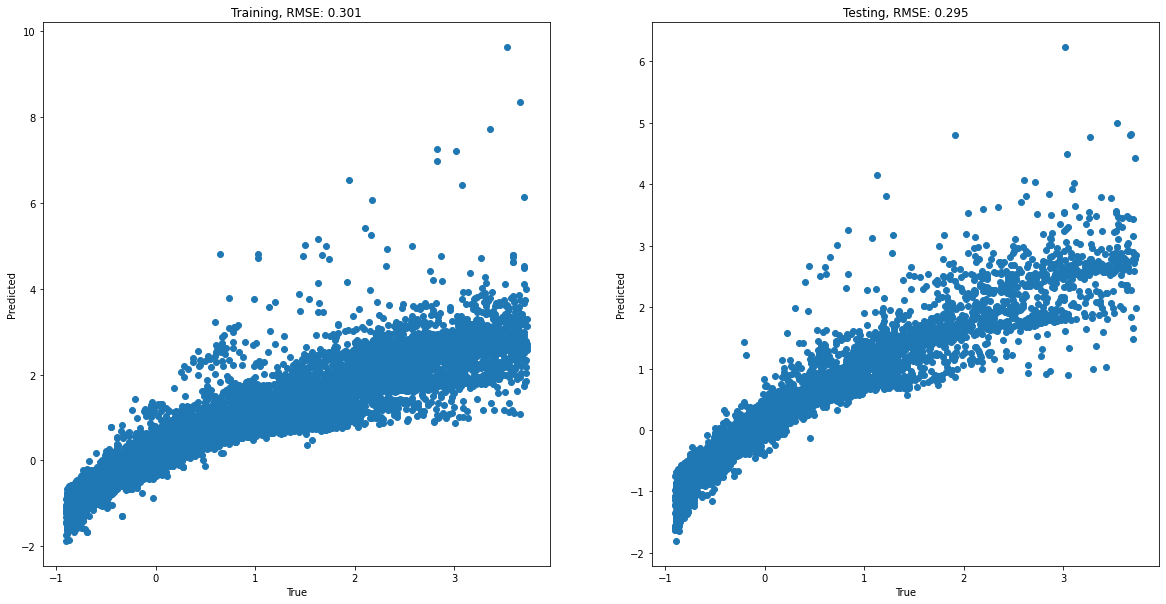

In [8]:
def plot_predictions(linear_model, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(y_train, linear_model.predict(X_train))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title('Training, RMSE: %1.3f' % numpy.sqrt(mean_squared_error(y_train, linear_model.predict(X_train))))
    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(y_test, linear_model.predict(X_test))
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title('Testing, RMSE: %1.3f' % numpy.sqrt(mean_squared_error(y_test, linear_model.predict(X_test))))

plot_predictions(linear_model, X_train, y_train, X_test, y_test)

Looking at our predictions, we see similar looking performance on training and testing sets, suggesting that overfitting is not an issue - though we do see some errors with the model struggling to predict the value of very expensive pebbles. That said, we see the same trend in both training and testing sets.

<AxesSubplot:>

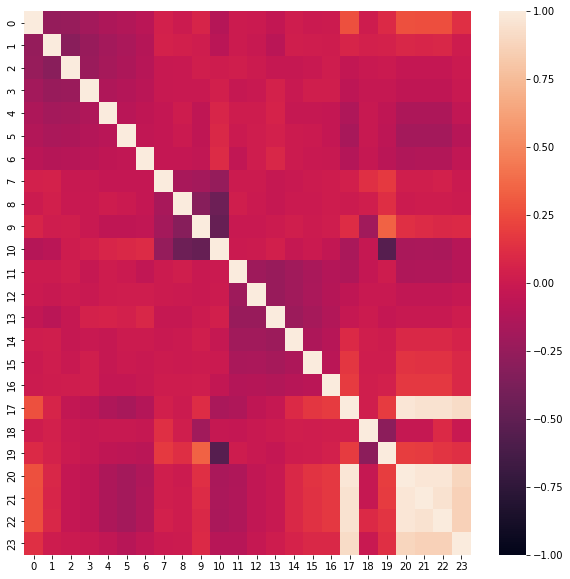

In [9]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(numpy.corrcoef(numpy.hstack([X_train, y_train]).transpose()), ax=ax, vmin=-1.0, vmax=1.0)

Finally, looking at correlation between terms we see that some predictors are quite strongly correlated with each other, indicating that we have some colinearity in the model that would best be avoided.

In summary, our model looks ok for a starting point, but if we were going to use this in anger we'd need to look closely at the colinearity in the data, and attempt to address the inability of our model to capture the price of expensive stones.

## PCA and Linear Regression

Rather than attempt to clean up our model, we'll instead throw our data at PCA. 

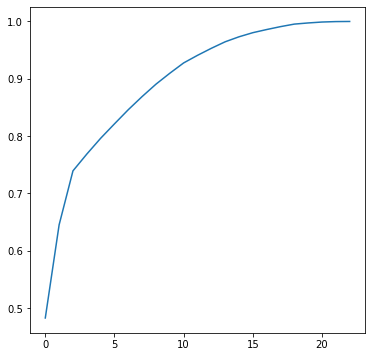

In [10]:
pca = decomposition.PCA()
pca.fit(X_train)
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(numpy.cumsum(pca.explained_variance_ratio_))

In [11]:
comp_90 = numpy.where(numpy.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]
comp_95 = numpy.where(numpy.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
print(comp_90)
print(comp_95)

9
12


As we often see, we have a number of dimensions with not much information. As we've done with PCA in the past, we can use this to reduce the number of dimensions we use in later processes, including regression.

In [12]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Before doing that though, let's revisit our correlation matrix. This now looks very different to what we had before.

<AxesSubplot:>

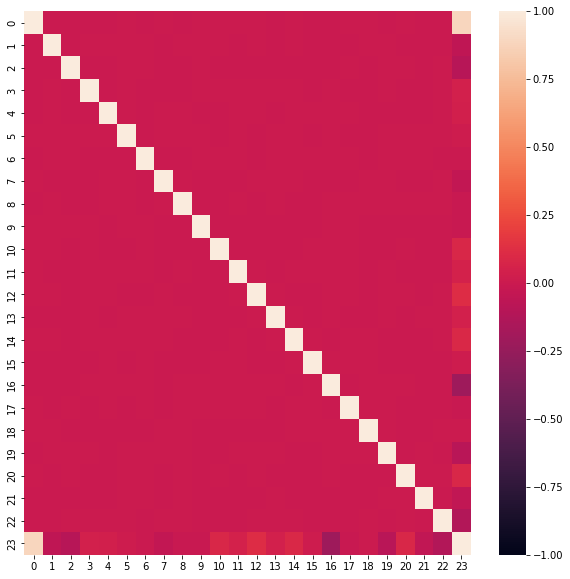

In [13]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(numpy.corrcoef(numpy.hstack([X_train_pca, y_train]).transpose()), ax=ax, vmin=-1.0, vmax=1.0)

Our predictors are now totally uncorrelated with each other. We have achieved the dream of having totally independent predictors. Note that this hasn't made our predictors and response massivley correlated (though the first term looks good).

### Regression with PCA

In [14]:
linear_model = sm.OLS(y_train, X_train_pca).fit()
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                          2.147e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:53:06   Log-Likelihood:                         -6890.6
No. Observations:               43152   AIC:                                  1.383e+04
Df Residuals:                   43129   BIC:                                  1.403e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

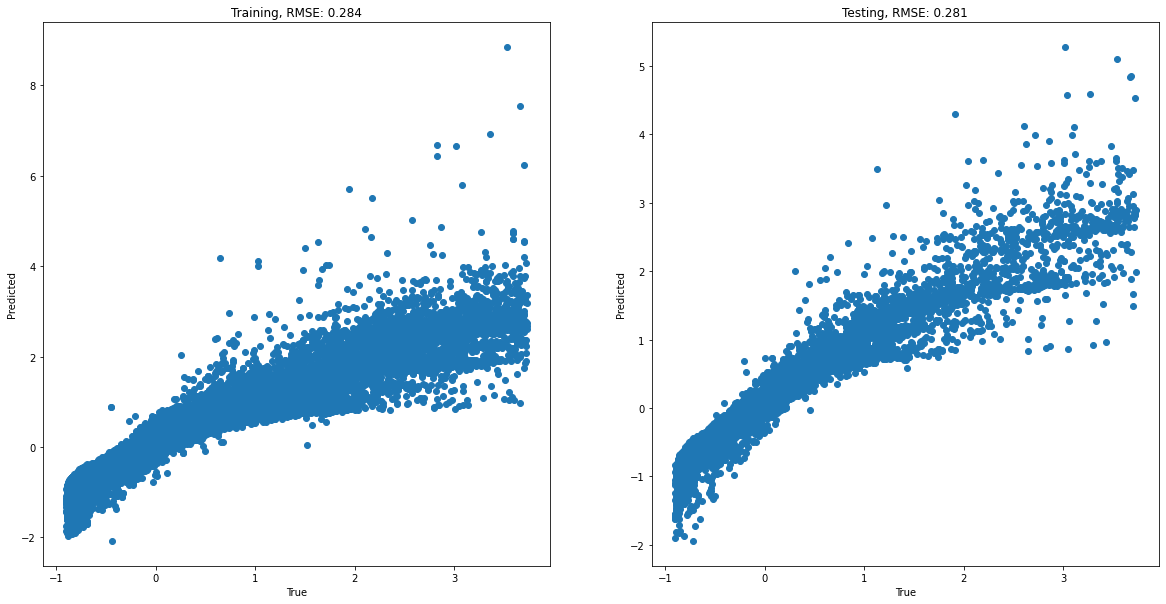

In [15]:
plot_predictions(linear_model, X_train_pca, y_train, X_test_pca, y_test)

Throwing the PCA'd data at our linear regressor we see that our predictions actually look a little better, and our $R^2$ has increased a bit. We still have some terms with poor p-values, though we can be certain that this is no longer due to any colinearity in the data.

### Regression with PCA and Dimension Reduction

Because I can, we'll now throw reduced versions of the data through PCA, considering versions that capture 90% and 95% of the variance.

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.808
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                          2.013e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:53:06   Log-Likelihood:                         -25729.
No. Observations:               43152   AIC:                                  5.148e+04
Df Residuals:                   43143   BIC:                                  5.155e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

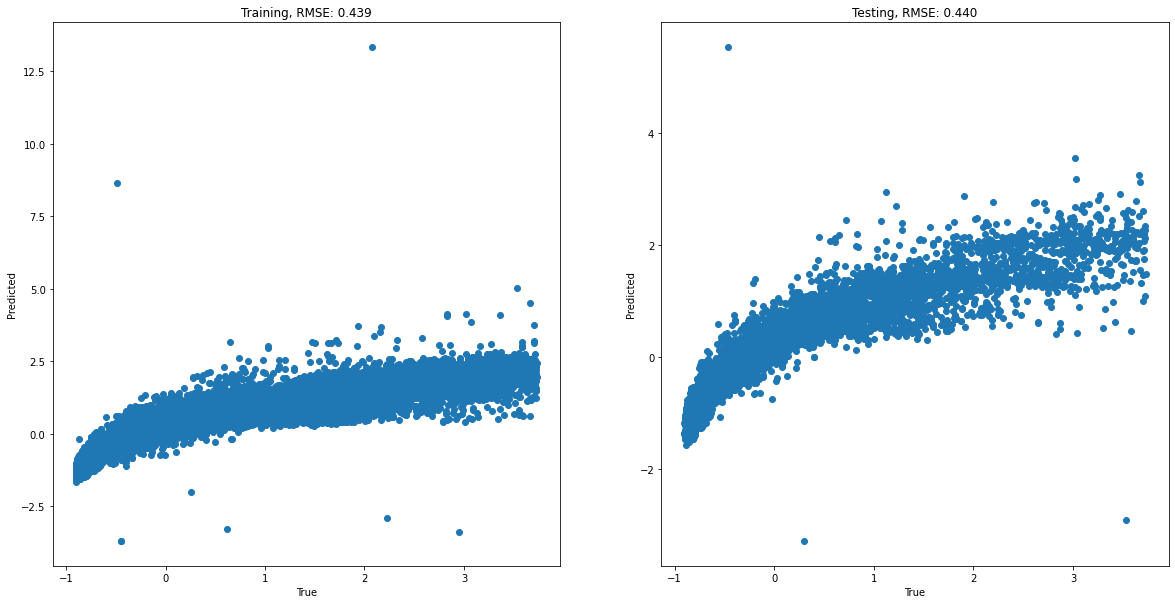

In [16]:
linear_model = sm.OLS(y_train, X_train_pca[:, 0:comp_90]).fit()
print(linear_model.summary())
plot_predictions(linear_model, X_train_pca[:, 0:comp_90], y_train, X_test_pca[:, 0:comp_90], y_test)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.818
Method:                 Least Squares   F-statistic:                          1.611e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):                        0.00
Time:                        13:53:06   Log-Likelihood:                         -24585.
No. Observations:               43152   AIC:                                  4.919e+04
Df Residuals:                   43140   BIC:                                  4.930e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

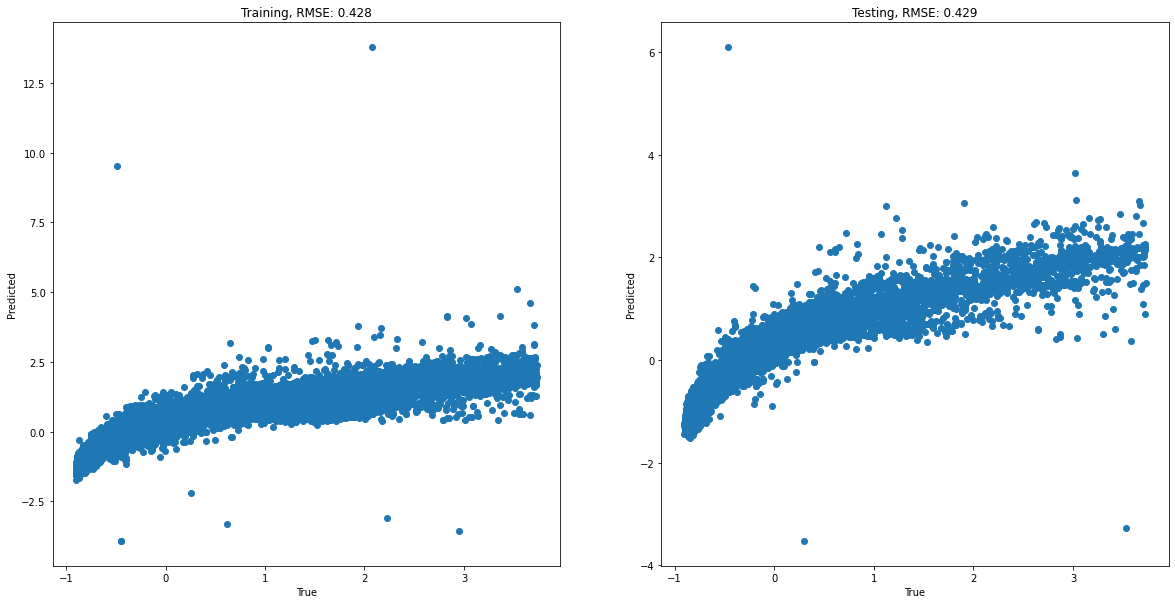

In [17]:
linear_model = sm.OLS(y_train, X_train_pca[:, 0:comp_95]).fit()
print(linear_model.summary())
plot_predictions(linear_model, X_train_pca[:, 0:comp_95], y_train, X_test_pca[:, 0:comp_95], y_test)

In both cases, we see a drop in performance, and term x7 in both models is not looking super important. Remember that our variables in PCA are in order of variance, but this is not the same as "usefulness for some given task".

## Some Thoughts

So, what was the point of all this?

One really nice property of PCA that we didn't really cover that much initially was the fact that the principal components are orthogonal, i.e. at right angles to each other. On it's own this probably doesn't mean too much, but in practice it means that each of the resultant dimensions are indepedent, which is very nice for something like linear regression which has this assumption (which is usually violated) of indepedent variables.

We can also use PCA to remove dimensions prior to feeding data into our regression model. In our case, we see no benefit from doing this, though this is in part due to an abundance of data (look at the number of training observations in the regression summaries above, it's not small) and thus not have even the slightest issue with overfitting, though in other cases you will see benefits doing this.

So, why not just use PCA as a common pre-processing step for linear regression? There are, of course, some limitations:
* The amount of variance in a component does not indicate how well correlated a component is with the response. Consider x7 in the PCA regression model (the sixth row/column in the corresponding correlation matrix), which has practicaly 0 correlation with the response.
* We lose interpretability. For our initial regression model, each term had a meaning. We had a set of terms that corresponded to colour, and a term corresponding to size and so on. We could easily understand the importance of individual factors. With PCA, each of our terms is now a weighted sum of the original terms, so the overall regression model is harder to interpret. 

The above doesn't mean that we shouldn't use PCA with regression (the ability to transform the data to obtain independent predictors is very cool), but we should consider what we're going to use the resultant model for, and what's important for our final application.